## Dynamic Precip Scaling based on Landcover

Take the LANDIS LAI re-gridded to 60 m and generate precip weights based on the LAI-SWE relationship

In [1]:
import glob
import rasterio as rs

In [2]:
# set the lowest krumholtz elevation
krumLow = 3274.2654

# load the dem:
with rs.open('/RHESSys/Como/auxdata/gridmet_dem_60m_crop.tiff') as ds:
    elev = ds.read(1)

orig_weights = np.load('./data/scaled_jepsen_weights_60m.npy')
    
# define the model

def LAIDEM2Weight(lai,dem,krumLow,orig_weights,capPer=95):
    '''
    Convert LAI and DEM values into snow scaling relationships above the lowest elevation of the krumholtz
    
    Inputs:
    lai - lai matrix [m2/m2]
    dem - elevation matrix [m]
    krumLow - lowest krumholtz elevation [m]
    orig_weights - original weights matrix [1]
    capPer - weights capping percentile, 95% suggested.
    
    Returns:
    weights - precipitations weights matrix [1]
    '''
    tundraLAI = 0.5 # lai of the tundra [m2/m2]
    beta1 = -42.659464
    beta2 = -0.012104
    beta3 = 0.012940
    intercept = 40.174769 
    
    k,l = lai.shape
    n,m = dem.shape
    #print lai.shape
    #print dem.shape
    
    if (k-n != 0) | (l-m != 0):
        print 'Matrices are not the same size'
        return None
    else:
        # create the output
        weights = np.ndarray((n,m))
        weights[:] = np.NaN 
        
        weights[dem < krumLow] = orig_weights[dem < krumLow] # fill the area below krumLow with 
        weights[lai == tundraLAI] = orig_weights[lai == tundraLAI] # fill in tundra areas that are still tundra areas
        
        # this just leaves the krumholtz region that is changing as the forest expands
        finder = np.isnan(weights)
        weights[finder] = np.exp((lai[finder] * beta1) + (dem[finder] * beta2) + (dem[finder] * lai[finder] * beta3) + intercept)  
        krumLAI = np.mean(lai[finder]) # save the lai of the krumholtz area 
        # check if there are any remaining NaNs:
        if np.sum(np.isnan(weights)) > 0:
            print "Output is not complete"
        
        # correct the weights so that there are not some unreasonably high ones
        maxWeight = np.percentile(weights,capPer)
        weights[weights>maxWeight] = maxWeight
        
        krumWeight = np.mean(weights[finder]) # save the precip weight of the krumholtz area
        
        return weights,krumLAI,krumWeight

In [3]:
files = glob.glob('./data/RHESSys_scenarios/LANDIS_LAI_*_60m.tiff')

In [4]:
files

['./data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2000_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2010_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2020_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2030_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2040_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2050_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2060_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2070_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2080_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2090_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_1_2100_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_2_2000_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_2_2010_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_2_2020_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_2_2030_60m.tiff',
 './data/RHESSys_scenarios/LANDIS_LAI_PGW_LP_2_2040_60m

In [5]:
krumlais = []
krumweights = []
years = []
scenarios = []
tracks = []

for fl in files:
    # pull things out of the filename
    year = int(fl.split('/')[-1].split('_')[-2])
    scen = int(fl.split('/')[-1].split('_')[-3])
    track2 = fl.split('/')[-1].split('_')[-4]
    track1 = fl.split('/')[-1].split('_')[-5]
    track = '%s_%s'%(track1,track2)
    years.append(year)
    scenarios.append(scen)
    tracks.append(track)
    
    # build the output filepath
    outfl = './data/RHESSys_scenarios/LANDIS_Pweight_%s_%s_%s.npy'%(track,scen,year)
    
    with rs.open(fl) as ds:
        lai = ds.read(1) # load the LAI data
    
    weights,krumlai,krumweight = LAIDEM2Weight(lai,elev,krumLow,orig_weights)
    
    krumlais.append(krumlai)
    krumweights.append(krumweight)
    
    # save the weights
    np.save(outfl,weights) # this has the same resolutin as the lai and dem used so it should match the gridding domain
    
dat = pd.DataFrame()
dat['year'] = years
dat['track'] = tracks
dat['scenarios'] = scenarios
dat['krumlai'] = krumlais
dat['krumweight'] = krumweights

In [6]:
dat.to_pickle('./data/dynamic_precipitation.pcl')

In [7]:
dat

,year,track,scenarios,krumlai,krumweight
0,2000,PGW_LP,1,2.736959,6.037752
1,2010,PGW_LP,1,2.433178,5.131501
2,2020,PGW_LP,1,2.352813,4.789137
3,2030,PGW_LP,1,2.315622,5.047437
4,2040,PGW_LP,1,2.184931,4.737545
5,2050,PGW_LP,1,2.110962,4.701338
6,2060,PGW_LP,1,2.083055,4.823302
7,2070,PGW_LP,1,2.114065,5.419591
8,2080,PGW_LP,1,2.156311,6.109703
9,2090,PGW_LP,1,2.223053,7.229266


## Tests

In [53]:
# test
with rs.open(files[0]) as ds:
    lai = ds.read(1)
    
weights,krumlai,krumweight = LAIDEM2Weight(lai,elev,krumLow,orig_weights)

(62, 83)
(62, 83)


In [56]:
print krumlai
print krumweight

2.73696
6.03775196473


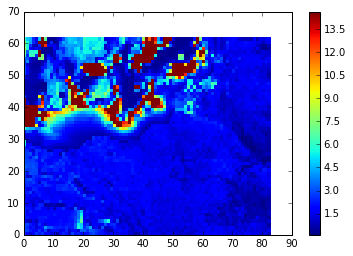

In [55]:
plt.pcolormesh(np.flipud(weights))
plt.colorbar()

In [48]:
np.exp(2.2)

9.025013499434122

5146
254


(0, 15)

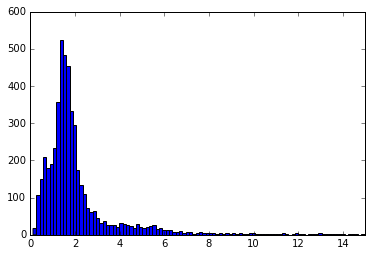

In [40]:
print 62*83
thresh = 15
tmp = np.reshape(weights,(62*83))
r = len(tmp)
tmp = tmp[tmp<thresh]
t = len(tmp)
print r-t
plt.hist(tmp,100);
plt.xlim(0,thresh)

In [43]:
np.percentile(np.reshape(weights,(62*83)),95)

14.639294385910034

In [23]:
np.exp(2.3025850929940459)

10.000000000000002